In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

PREV_GAMES = 5
weight = np.array([.05, .1, .2, .3, .35])
#weight = [.15,.35,.5]
#weight = [.01,.04,.05,.1,.2,.3,.3]
dir_name = os.getcwd()
csv = dir_name + '/data/match_stats.csv'
data = pd.read_csv(csv)

In [2]:
# get net scores

data['goal_diff'] = data['FTHG'] - data['FTAG']
data['shot_diff'] = data['HST'] - data['AST']
data['corner_diff'] = data['HC'] - data['AC']

data[data['FTR'] == 'D'].shape[0], data[data['FTR'] == 'A'].shape[0], data[data['FTR'] == 'H'].shape[0]

(71, 128, 181)

In [3]:
counter = {}
res = {}

def update_team_data(team, raw_dat, results, data_vec, is_away):
    '''
    Builds dictionary that maps a team to its weighted average score in three categories over Prev_Games.
    
    Parameters:
    team (str): team name
    raw_dat (dic): dictionary that maps a team its raw data over the past Prev_games
    results (dic): maps a team to its weighted average (over Prev_GAMES) score in three categories
    data_vec (np.array): the raw data. Columns 2-4 and 62-65 in the orginial dataframe.
    is_away (bool): Since the data is of the form Home-Away, we must reverse the sign when computing the
                    score of the away team.
    
    '''
    if is_away:
        sgn = -1
    else:
        sgn = 1
    if team not in raw_dat:
        raw_dat[team] = sgn * data_vec
    elif raw_dat[team].shape[0] < PREV_GAMES:
        raw_dat[team] = np.vstack((raw_dat[team], sgn * data_vec))
    else:
        results[team] = dict(zip(['goal', 'shot', 'corner'], np.average(raw_dat[team].astype('float'), axis=0, weights=weight)))
        raw_dat[team] = np.vstack((raw_dat[team][1:,], sgn * data_vec))
   
    return results
        


def get_avg_diff(row, dic, results):
    '''
    Creates a list containing the difference between the home team and the away team in
    the three categories from the results dictionary
    
    Parameters:
    row (series): A row of the form (home team name, away team name, goal diff, shot diff, corner diff)
    dic: Dictionary that maps a team its raw data over the past Prev_games
    results (dic): Maps a team to its weighted average (over Prev_GAMES) score in three categories
    
    returns:
    diff (lst): list of length 3 containing the difference between the home team and the away team in
    the three categories from the results dictionary
    
    
    '''
    update_team_data(row[0], dic, results, row[2:5], False)
    res = update_team_data(row[1], dic, results, row[2:5], True)
    #print(res.keys())
    if row[0] in res and row[1] in res:
        diff = []
        for key in results[row[0]].keys():
            diff.append(results[row[0]][key] - results[row[1]][key])
            
        return diff
    
    return [0,0,0]



#Create data matrix
X_mat = data.iloc[:,np.r_[2:4, 62:65]].apply(
    get_avg_diff, axis=1, dic=counter, results=res, result_type='expand').iloc[10 * PREV_GAMES:,].reset_index(drop=True)
X_mat.columns = ['goals', 'shots', 'corners']
label_encoder = preprocessing.LabelEncoder()
y = pd.DataFrame(label_encoder.fit_transform(data.iloc[10 * PREV_GAMES:,6].reset_index(drop=True)))
y.columns = ['Result']


In [4]:
#Split data into training, validation, and test sets

tr, val, tst = np.split(pd.concat((X_mat,y),axis=1).sample(frac=1, random_state=42),
                         [int(len(X_mat) * .6), int(len(X_mat) * .8)])
X_tr = tr.iloc[:,:3]
y_tr = tr.iloc[:,3]
X_val = val.iloc[:,:3]
y_val = val.iloc[:,3]
X_tst = tst.iloc[:,:3]
y_tst = tst.iloc[:,3]


In [5]:
def tune_hyperparams(mod, Xtr, ytr, Xval, yval, param_grid, fit_param_dic):
    '''
    Fits model for each element in the cartesian product of the lists of possible values of each parameter
    given by the param_grid. Then selects the best model based on the validation accuracy.
    
    Parameters:
    mod (obj): A multiclass classifier
    Xtr (np.array): training data
    ytr (np.array): 1D array of training labels
    Xval (np.array): validation data
    yval (np.array): 1D array of validation labels
    param_grid (dic): maps each parameter to a list of values to be tested
    fit_param_dic (dic): used to implement early stopping for xgboost. Is an empty dictionary for all other classifiers
    
    Returns:
    validation_scores (dic): maps a given combination of parameters to the validation score for that model
    best_params_dic (dic): maps the parameter to its optimals value
    
    
    '''
    validation_scores = {}
    keys, vals = zip(*sorted(param_grid.items()))
    for it, params in enumerate(itertools.product(*vals)):
        #print(dict(zip(keys, params)))
        if it % 5 == 0:
            print(it, params)
        mod.set_params(**dict(zip(keys, params)))
        pipe = Pipeline(steps=[('scaler', preprocessing.StandardScaler()), ('clf', mod)])
        pipe.fit(Xtr, ytr, **fit_param_dic)
        validation_scores[params] = pipe.score(Xval, yval)
    best_params = max(validation_scores, key=validation_scores.get)
    best_params_dic = dict(zip(keys, best_params))
    
    return validation_scores, best_params_dic

0 (0.01, 0, 1, 3, 0, 325, 'multi:softprob', 1)
5 (0.019731543624161074, 0, 1, 3, 0, 325, 'multi:softprob', 1)
10 (0.029463087248322146, 0, 1, 3, 0, 325, 'multi:softprob', 1)
15 (0.03919463087248322, 0, 1, 3, 0, 325, 'multi:softprob', 1)
20 (0.04892617449664429, 0, 1, 3, 0, 325, 'multi:softprob', 1)
25 (0.05865771812080536, 0, 1, 3, 0, 325, 'multi:softprob', 1)
30 (0.06838926174496643, 0, 1, 3, 0, 325, 'multi:softprob', 1)
35 (0.07812080536912751, 0, 1, 3, 0, 325, 'multi:softprob', 1)
40 (0.08785234899328857, 0, 1, 3, 0, 325, 'multi:softprob', 1)
45 (0.09758389261744965, 0, 1, 3, 0, 325, 'multi:softprob', 1)
50 (0.10731543624161072, 0, 1, 3, 0, 325, 'multi:softprob', 1)
55 (0.1170469798657718, 0, 1, 3, 0, 325, 'multi:softprob', 1)
60 (0.12677852348993288, 0, 1, 3, 0, 325, 'multi:softprob', 1)
65 (0.13651006711409394, 0, 1, 3, 0, 325, 'multi:softprob', 1)
70 (0.14624161073825503, 0, 1, 3, 0, 325, 'multi:softprob', 1)
75 (0.1559731543624161, 0, 1, 3, 0, 325, 'multi:softprob', 1)
80 (0.165

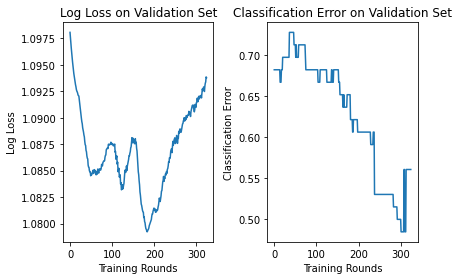

In [6]:
#Note parameters were tuned one, or two at time to cut down on computation time, so the grid does not reflect all values 
#tested
param_grids = {'xgb': 
               {'subsample': [1], 
                'gamma':[0],
                'lambda': [1], 
                'eta': np.linspace(1e-2,.3,150), 'n_estimators': [325],
                'min_child_weight': [0], 'max_depth': [3],
                'objective': ['multi:softprob'] },
               'svc':
               {'C': [100000], 'gamma': [.01], 'kernel':['rbf']},
               'softmax': 
               {'C': np.geomspace(1e-2, 1e-1, 200), 'multi_class': ['multinomial'], 'solver': ['sag']} 
            }
optimal_mods = []
mods = [('xgb', XGBClassifier(use_label_encoder=False)), ('svc', SVC()), ('softmax', LogisticRegression())]
for name, mod in mods:
    fit_params = {}
    if name == 'xgb':
        fit_params = {'clf__early_stopping_rounds': 150, 'clf__eval_set': [(X_val.values, y_val.values)], 
                      'clf__eval_metric':['mlogloss','merror'], 'clf__verbose':False}
    val_scores, best_params = tune_hyperparams(mod, X_tr, y_tr, X_val, y_val, param_grids[name], fit_params)
    print(best_params)
    pipe = Pipeline(steps=[('scaler', preprocessing.StandardScaler()), (name, mod.set_params(**best_params))])
    optimal_mods.append(pipe)
top_score = 0
for mod in optimal_mods:
    mod.fit(pd.concat((X_tr, X_val)), pd.concat((y_tr, y_val)))  #refit best models on training and validation sets
    test_score = mod.score(X_tst, y_tst)
    print(test_score, mod[1])
    if test_score >= top_score:
        best_mod = mod
        top_score = test_score


#Plot validation loss to see if early stopping is needed
fig, ax = plt.subplots(1,2)
eval_res = optimal_mods[0]['xgb'].evals_result()
ax[0].plot(range(0, len(eval_res['validation_0']['mlogloss'])), eval_res['validation_0']['mlogloss'])
ax[1].plot(range(0, len(eval_res['validation_0']['merror'])), eval_res['validation_0']['merror'])
ax[0].set(xlabel = 'Training Rounds', ylabel = 'Log Loss')
ax[1].set(xlabel='Training Rounds', ylabel='Classification Error')
ax[0].set_title('Log Loss on Validation Set')
ax[1].set_title('Classification Error on Validation Set')
plt.tight_layout()
plt.show()   


In [7]:
def simple_strat(row):
    '''
    Defines a simple betting strategy where 1 dollar is bet on the outcome with the highest probability
    
    Parameters: row containing prediction, true result and betting information
    
    Returns: 1 if bet is lost, and the payout given by the odds if won
    
    
    
    '''
    if row[0] != row[1]:
        return -1 
    if row[0] == 'H':
        return row[4]
    elif row[0] == 'A':
        return row[6]
    else:
        return row[5]

MIN_PROB = .5
FACTOR = 5
def conservative_strat(row):
    '''
    Defines a betting strategy where a bet is placed only if the probability associated with the most likely class is
    .5 or greater. If a bet is made, the wager is proportional to the product of the probability and some constant.
    
    Parameters: row containing prediction, true result and betting information
    
    Returns: 1 if bet is lost, and the payout given by the odds if won    
    '''
    if row[2] >= MIN_PROB:
        wager = round(row[2] * FACTOR, 2)
        if row[0] != row[1]:
            return -wager
        elif row[0] == 'H':
            return row[4] * wager
        elif row[0] == 'A':
            return row[6] * wager
        else:
            return row[5] * wager
    else:
        return 0

In [8]:
ypred = best_mod.predict(X_tst)
ys = np.vstack((ypred, y_tst))
ys = np.where(ys==2,'H', np.where(ys==0, 'A', 'D')) #convert back to original labels
probs = np.max(best_mod.predict_proba(X_tst), axis=1)
pred_target_prob = pd.DataFrame(np.vstack((ys, probs)).T, columns=['ypred', 'ytest', 'predicted_prob'])
pred_target_prob = pred_target_prob.astype({'predicted_prob': float})
odds = data.iloc[10 * PREV_GAMES:,23:26].reset_index(drop=True).iloc[y_tst.index].reset_index()
winnings_dat = pd.concat((pred_target_prob, odds), axis=1)
#print(winnings_dat)

for strat in [simple_strat, conservative_strat]:
    winnings_dat['winnings'] = winnings_dat.apply(strat, axis=1)
    print(sum(winnings_dat['winnings']))
    print(winnings_dat)
    print(winnings_dat.iloc[winnings_dat['winnings'].idxmax(),:])


53.62999999999999
   ypred ytest  predicted_prob  index  B365H  B365D  B365A  winnings
0      A     D        0.485579    236   6.00   4.20   1.61     -1.00
1      H     H        0.414305    207   2.35   3.50   3.20      2.35
2      H     H        0.452513    212   1.95   3.80   4.00      1.95
3      A     D        0.530878    301   2.30   3.20   3.60     -1.00
4      H     H        0.482454    251   1.55   4.20   7.00      1.55
..   ...   ...             ...    ...    ...    ...    ...       ...
61     H     D        0.450442    188   2.40   3.40   3.20     -1.00
62     H     H        0.534714     71   1.40   5.00   9.00      1.40
63     H     H        0.553682    106   1.33   5.75  10.00      1.33
64     H     A        0.423049    270   2.10   3.60   3.75     -1.00
65     A     H        0.569633    102   2.90   3.20   2.75     -1.00

[66 rows x 8 columns]
ypred                   H
ytest                   H
predicted_prob    0.40502
index                 214
B365H                5.75
B